# Phishing Domain Classifier

## Import Libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

## Importing the dataset

In [11]:
dataset = pd.read_csv('E:/DataScience/projects/phishing_detection/data/raw/phishing_data.csv')
dataset.sample(5)

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
7692,-1,-1,1,1,1,-1,0,-1,1,1,...,1,1,-1,1,1,1,1,1,1,-1
9420,1,-1,1,1,1,-1,0,1,-1,-1,...,-1,1,1,1,-1,-1,1,0,1,1
689,1,-1,1,1,1,-1,0,0,1,-1,...,-1,1,1,1,-1,-1,1,0,-1,-1
7324,1,-1,1,1,1,-1,1,1,-1,1,...,1,1,-1,1,1,1,1,0,1,1
7254,-1,1,1,-1,1,1,1,1,1,-1,...,-1,-1,1,1,1,1,1,1,1,1


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   having_IP_Address            11055 non-null  int64
 1   URL_Length                   11055 non-null  int64
 2   Shortining_Service           11055 non-null  int64
 3   having_At_Symbol             11055 non-null  int64
 4   double_slash_redirecting     11055 non-null  int64
 5   Prefix_Suffix                11055 non-null  int64
 6   having_Sub_Domain            11055 non-null  int64
 7   SSLfinal_State               11055 non-null  int64
 8   Domain_registeration_length  11055 non-null  int64
 9   Favicon                      11055 non-null  int64
 10  port                         11055 non-null  int64
 11  HTTPS_token                  11055 non-null  int64
 12  Request_URL                  11055 non-null  int64
 13  URL_of_Anchor                11055 non-null  i

In [13]:
dataset.columns

Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report',
       'Result'],
      dtype='object')

In [14]:
for col in dataset.columns:
    print(dataset[col].value_counts())

having_IP_Address
 1    7262
-1    3793
Name: count, dtype: int64
URL_Length
-1    8960
 1    1960
 0     135
Name: count, dtype: int64
Shortining_Service
 1    9611
-1    1444
Name: count, dtype: int64
having_At_Symbol
 1    9400
-1    1655
Name: count, dtype: int64
double_slash_redirecting
 1    9626
-1    1429
Name: count, dtype: int64
Prefix_Suffix
-1    9590
 1    1465
Name: count, dtype: int64
having_Sub_Domain
 1    4070
 0    3622
-1    3363
Name: count, dtype: int64
SSLfinal_State
 1    6331
-1    3557
 0    1167
Name: count, dtype: int64
Domain_registeration_length
-1    7389
 1    3666
Name: count, dtype: int64
Favicon
 1    9002
-1    2053
Name: count, dtype: int64
port
 1    9553
-1    1502
Name: count, dtype: int64
HTTPS_token
 1    9259
-1    1796
Name: count, dtype: int64
Request_URL
 1    6560
-1    4495
Name: count, dtype: int64
URL_of_Anchor
 0    5337
-1    3282
 1    2436
Name: count, dtype: int64
Links_in_tags
 0    4449
-1    3956
 1    2650
Name: count, dtype: i

In [15]:
# Split the dataset between dependent and independent variable as an array
X = dataset.drop('Result', axis=1).replace(-1, 'Phish').replace(1,'Legit').replace(0,'Sus')
y = dataset['Result'].replace(-1,0)

# # Split the dataset between dependent and independent variable as an array
# X = dataset.drop('Result', axis=1)
# y = dataset['Result'].replace(-1,0)

In [16]:
# def one_hot_encode_input(input_data, columns):

#     # Create a DataFrame from the input data
#     df = pd.DataFrame([input_data], columns=columns)

#     # Initialize the target one-hot encoded columns
#     one_hot_columns = [
#         'having_IP_Address_Legit', 'having_IP_Address_Phish',
#         'URL_Length_Legit', 'URL_Length_Phish', 'URL_Length_Sus',
#         'Shortining_Service_Legit', 'Shortining_Service_Phish',
#         'having_At_Symbol_Legit', 'having_At_Symbol_Phish',
#         'double_slash_redirecting_Legit', 'double_slash_redirecting_Phish',
#         'Prefix_Suffix_Legit', 'Prefix_Suffix_Phish', 'having_Sub_Domain_Legit',
#         'having_Sub_Domain_Phish', 'having_Sub_Domain_Sus',
#         'SSLfinal_State_Legit', 'SSLfinal_State_Phish', 'SSLfinal_State_Sus',
#         'Domain_registeration_length_Legit', 'Domain_registeration_length_Phish',
#         'Favicon_Legit', 'Favicon_Phish', 'port_Legit', 'port_Phish',
#         'HTTPS_token_Legit', 'HTTPS_token_Phish', 'Request_URL_Legit',
#         'Request_URL_Phish', 'URL_of_Anchor_Legit', 'URL_of_Anchor_Phish',
#         'URL_of_Anchor_Sus', 'Links_in_tags_Legit', 'Links_in_tags_Phish',
#         'Links_in_tags_Sus', 'SFH_Legit', 'SFH_Phish', 'SFH_Sus',
#         'Submitting_to_email_Legit', 'Submitting_to_email_Phish',
#         'Abnormal_URL_Legit', 'Abnormal_URL_Phish', 'Redirect_Legit',
#         'Redirect_Sus', 'on_mouseover_Legit', 'on_mouseover_Phish',
#         'RightClick_Legit', 'RightClick_Phish', 'popUpWidnow_Legit',
#         'popUpWidnow_Phish', 'Iframe_Legit', 'Iframe_Phish', 'age_of_domain_Legit',
#         'age_of_domain_Phish', 'DNSRecord_Legit', 'DNSRecord_Phish',
#         'web_traffic_Legit', 'web_traffic_Phish', 'web_traffic_Sus',
#         'Page_Rank_Legit', 'Page_Rank_Phish', 'Google_Index_Legit',
#         'Google_Index_Phish', 'Links_pointing_to_page_Legit',
#         'Links_pointing_to_page_Phish', 'Links_pointing_to_page_Sus',
#         'Statistical_report_Legit', 'Statistical_report_Phish'
#     ]

#     # Initialize an empty dictionary to hold the one-hot encoded results
#     one_hot_dict = {col: 0 for col in one_hot_columns}

#     # Define the mapping for each column based on its input value (-1, 0, 1)
#     for column in df.columns:
#         value = df[column].values[0]
#         if value == 1:
#             one_hot_dict[f'{column}_Legit'] = 1
#         elif value == -1:
#             one_hot_dict[f'{column}_Phish'] = 1
#         elif value == 0:
#             if f'{column}_Sus' in one_hot_dict:
#                 one_hot_dict[f'{column}_Sus'] = 1

#     # Convert the one-hot dictionary back into a DataFrame
#     one_hot_df = pd.DataFrame([one_hot_dict])
#     return one_hot_df

# # Input data example (you would replace this with real input data)
# input_data = [-1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 0, -1, 1, 1, 0, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1]

# # Input column names
# columns = ['having_IP_Address', 'URL_Length', 'Shortining_Service',
#         'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
#         'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
#         'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
#         'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
#         'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
#         'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
#         'Google_Index', 'Links_pointing_to_page', 'Statistical_report']

# # One-hot encode the input
# output = one_hot_encode_input(input_data, columns).values
# output

In [17]:
# best_clf.predict(output)

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = dataset.columns.tolist()[:-1]

column_transformer = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(), categorical_features)
    ],
    remainder='drop'
)
X_encoded = column_transformer.fit_transform(X)

encoded_feature_names = column_transformer.named_transformers_['one_hot_encoder'].get_feature_names_out(categorical_features)

X_encoded = pd.DataFrame(X_encoded, columns=encoded_feature_names)

# ohe = OneHotEncoder()
# X_encoded = ohe.fit_transform(X)
X_encoded


,having_IP_Address_Legit,having_IP_Address_Phish,URL_Length_Legit,URL_Length_Phish,URL_Length_Sus,Shortining_Service_Legit,Shortining_Service_Phish,having_At_Symbol_Legit,having_At_Symbol_Phish,double_slash_redirecting_Legit,...,web_traffic_Sus,Page_Rank_Legit,Page_Rank_Phish,Google_Index_Legit,Google_Index_Phish,Links_pointing_to_page_Legit,Links_pointing_to_page_Phish,Links_pointing_to_page_Sus,Statistical_report_Legit,Statistical_report_Phish
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
11051,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
11052,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
11053,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


## Splitting the dataset into the Training set and Test set

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

## Lazy Classifier

In [20]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

models

  3%|▎         | 1/31 [00:00<00:18,  1.60it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.9393939393939394, 'Balanced Accuracy': 0.9369381952618578, 'ROC AUC': 0.9369381952618578, 'F1 Score': 0.9392797964706645, 'Time taken': 0.6247918605804443}


  6%|▋         | 2/31 [00:00<00:12,  2.34it/s]

{'Model': 'BaggingClassifier', 'Accuracy': 0.9719583898688376, 'Balanced Accuracy': 0.9709681029194781, 'ROC AUC': 0.9709681029194782, 'F1 Score': 0.9719400265449771, 'Time taken': 0.2871675491333008}
{'Model': 'BernoulliNB', 'Accuracy': 0.9280868385345997, 'Balanced Accuracy': 0.9263677282448317, 'ROC AUC': 0.9263677282448316, 'F1 Score': 0.9280272811435175, 'Time taken': 0.05733799934387207}


 23%|██▎       | 7/31 [00:01<00:04,  5.81it/s]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.9402985074626866, 'Balanced Accuracy': 0.9383747243820355, 'ROC AUC': 0.9383747243820356, 'F1 Score': 0.9402240230920895, 'Time taken': 0.5346956253051758}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.966078697421981, 'Balanced Accuracy': 0.9654797824897627, 'ROC AUC': 0.9654797824897627, 'F1 Score': 0.9660733392118288, 'Time taken': 0.06783175468444824}
{'Model': 'DummyClassifier', 'Accuracy': 0.5567616463138851, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.39824147972829316, 'Time taken': 0.036200523376464844}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.9706015377657169, 'Balanced Accuracy': 0.9696455511530364, 'ROC AUC': 0.9696455511530363, 'F1 Score': 0.9705839592324556, 'Time taken': 0.04863452911376953}


 35%|███▌      | 11/31 [00:02<00:04,  4.70it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.9755766621438263, 'Balanced Accuracy': 0.974737644854855, 'ROC AUC': 0.9747376448548551, 'F1 Score': 0.9755634381558159, 'Time taken': 0.9206323623657227}
{'Model': 'GaussianNB', 'Accuracy': 0.7005879692446857, 'Balanced Accuracy': 0.7308008256105041, 'ROC AUC': 0.7308008256105042, 'F1 Score': 0.6837506625074016, 'Time taken': 0.14568567276000977}


 39%|███▊      | 12/31 [00:03<00:04,  3.83it/s]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.9543193125282677, 'Balanced Accuracy': 0.9526305973242262, 'ROC AUC': 0.9526305973242262, 'F1 Score': 0.9542651166446682, 'Time taken': 0.4643080234527588}


 42%|████▏     | 13/31 [00:11<00:36,  2.01s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.9687924016282226, 'Balanced Accuracy': 0.9683329465011025, 'ROC AUC': 0.9683329465011026, 'F1 Score': 0.9687907717241642, 'Time taken': 8.360717535018921}


 45%|████▌     | 14/31 [00:20<01:01,  3.60s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.9687924016282226, 'Balanced Accuracy': 0.9683329465011025, 'ROC AUC': 0.9683329465011026, 'F1 Score': 0.9687907717241642, 'Time taken': 8.718642711639404}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.9298959746720941, 'Balanced Accuracy': 0.927160181700625, 'ROC AUC': 0.9271601817006252, 'F1 Score': 0.9297499831095368, 'Time taken': 0.09843945503234863}


 58%|█████▊    | 18/31 [00:20<00:18,  1.42s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.9402985074626866, 'Balanced Accuracy': 0.9383747243820355, 'ROC AUC': 0.9383747243820356, 'F1 Score': 0.9402240230920895, 'Time taken': 0.16370916366577148}
{'Model': 'LogisticRegression', 'Accuracy': 0.939846223428313, 'Balanced Accuracy': 0.9377604900611748, 'ROC AUC': 0.9377604900611748, 'F1 Score': 0.9397599741967337, 'Time taken': 0.08329176902770996}
{'Model': 'NearestCentroid', 'Accuracy': 0.9226594301221167, 'Balanced Accuracy': 0.9206614002221523, 'ROC AUC': 0.9206614002221523, 'F1 Score': 0.9225770405147383, 'Time taken': 0.05713844299316406}


 68%|██████▊   | 21/31 [00:37<00:28,  2.86s/it]

{'Model': 'NuSVC', 'Accuracy': 0.9335142469470827, 'Balanced Accuracy': 0.9302015119614052, 'ROC AUC': 0.9302015119614052, 'F1 Score': 0.9333202356215693, 'Time taken': 16.364657878875732}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.8824061510628675, 'Balanced Accuracy': 0.8850320794442879, 'ROC AUC': 0.8850320794442879, 'F1 Score': 0.8827372050160169, 'Time taken': 0.05884385108947754}
{'Model': 'Perceptron', 'Accuracy': 0.9054726368159204, 'Balanced Accuracy': 0.905955005885376, 'ROC AUC': 0.9059550058853761, 'F1 Score': 0.9056131099149012, 'Time taken': 0.05466413497924805}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.7263681592039801, 'Balanced Accuracy': 0.7303378703227839, 'ROC AUC': 0.7303378703227839, 'F1 Score': 0.7272304671054118, 'Time taken': 0.11648964881896973}


 81%|████████  | 25/31 [00:38<00:08,  1.37s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9751243781094527, 'Balanced Accuracy': 0.9740193802947661, 'ROC AUC': 0.9740193802947662, 'F1 Score': 0.9751037764961855, 'Time taken': 0.7419252395629883}
{'Model': 'RidgeClassifier', 'Accuracy': 0.9298959746720941, 'Balanced Accuracy': 0.927160181700625, 'ROC AUC': 0.9271601817006252, 'F1 Score': 0.9297499831095368, 'Time taken': 0.05639052391052246}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.9298959746720941, 'Balanced Accuracy': 0.927160181700625, 'ROC AUC': 0.9271601817006252, 'F1 Score': 0.9297499831095368, 'Time taken': 0.08104729652404785}
{'Model': 'SGDClassifier', 'Accuracy': 0.9208502939846224, 'Balanced Accuracy': 0.9184125234171654, 'ROC AUC': 0.9184125234171654, 'F1 Score': 0.9207268127066576, 'Time taken': 0.1144709587097168}


 87%|████████▋ | 27/31 [00:42<00:06,  1.68s/it]

{'Model': 'SVC', 'Accuracy': 0.9620081411126187, 'Balanced Accuracy': 0.9604718247981565, 'ROC AUC': 0.9604718247981564, 'F1 Score': 0.9619653763246673, 'Time taken': 4.567631483078003}


 97%|█████████▋| 30/31 [00:43<00:01,  1.11s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.9733152419719584, 'Balanced Accuracy': 0.9722906546859198, 'ROC AUC': 0.9722906546859198, 'F1 Score': 0.9732962369054636, 'Time taken': 0.7972056865692139}
[LightGBM] [Info] Number of positive: 4926, number of negative: 3918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 8844, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556988 -> initscore=0.228946
[LightGBM] [Info] Start training from score 0.228946


100%|██████████| 31/31 [00:43<00:00,  1.42s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.9701492537313433, 'Balanced Accuracy': 0.9691353470714037, 'ROC AUC': 0.9691353470714037, 'F1 Score': 0.9701297056769111, 'Time taken': 0.2151796817779541}


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.98,0.97,0.97,0.98,0.92
RandomForestClassifier,0.98,0.97,0.97,0.98,0.74
XGBClassifier,0.97,0.97,0.97,0.97,0.80
BaggingClassifier,0.97,0.97,0.97,0.97,0.29
ExtraTreeClassifier,0.97,0.97,0.97,0.97,0.05
LGBMClassifier,0.97,0.97,0.97,0.97,0.22
LabelSpreading,0.97,0.97,0.97,0.97,8.72
LabelPropagation,0.97,0.97,0.97,0.97,8.36
DecisionTreeClassifier,0.97,0.97,0.97,0.97,0.07


## TruncatedSVD Dimentionality Reduction

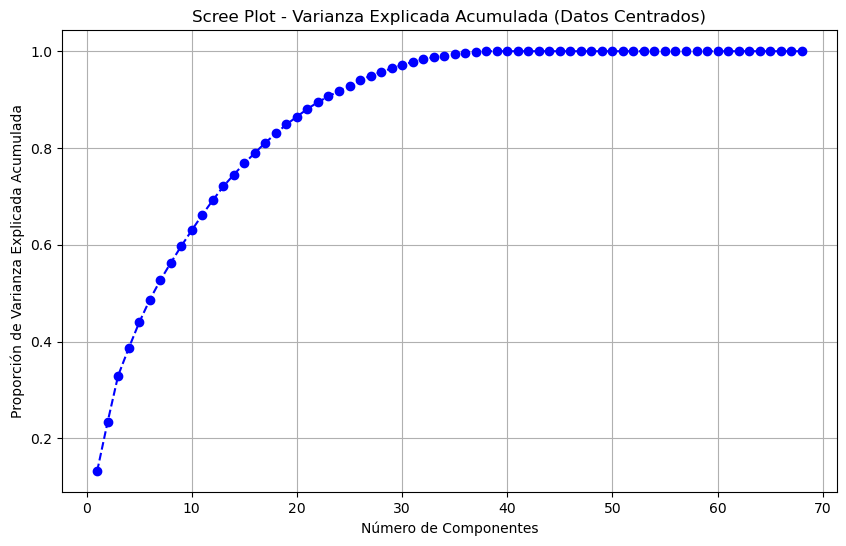

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

# Centrar los datos (Esto puede convertir la matriz en densa y consumir mucha memoria)
scaler = StandardScaler(with_mean=True, with_std=False)
X_centered = scaler.fit_transform(X_encoded)

# Definir el número de componentes
n_components = X_centered.shape[1]

# Aplicar Truncated SVD
svd = TruncatedSVD(n_components = n_components, random_state=42)
svd.fit(X_centered)

# Obtener la varianza explicada
explained_variance_ratio = svd.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Graficar el Scree Plot
components = np.arange(1, n_components + 1)
plt.figure(figsize=(10, 6))
plt.plot(components, cumulative_explained_variance, marker='o', linestyle='--', color='b')
plt.title('Scree Plot - Varianza Explicada Acumulada (Datos Centrados)')
plt.xlabel('Número de Componentes')
plt.ylabel('Proporción de Varianza Explicada Acumulada')
plt.grid(True)
plt.show()


In [22]:
# Suponiendo que deseas retener el 90% de la varianza
desired_variance = 1.00

# Encontrar el número de componentes necesarios
num_components = np.argmax(cumulative_explained_variance >= desired_variance) + 1

print(f"Número de componentes necesarios para retener el {desired_variance*100}% de la varianza: {num_components}")

Número de componentes necesarios para retener el 100.0% de la varianza: 38


In [23]:
# Crear y ajustar el modelo TruncatedSVD con el número seleccionado de componentes
svd_final = TruncatedSVD(n_components=num_components, random_state=42)
X_reduced = svd_final.fit_transform(X_encoded)

# Convertir a DataFrame
X_reduced = pd.DataFrame(X_reduced, columns=[f'Component_{i+1}' for i in range(num_components)])

# Verificar las dimensiones
print(f"Dimensión original: {X_encoded.shape}")
print(f"Dimensión reducida: {X_reduced.shape}")


Dimensión original: (11055, 68)
Dimensión reducida: (11055, 38)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

models

  3%|▎         | 1/31 [00:02<01:14,  2.48s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.9389416553595658, 'Balanced Accuracy': 0.9364279911802251, 'ROC AUC': 0.9364279911802251, 'F1 Score': 0.9388226339631726, 'Time taken': 2.480705976486206}


  6%|▋         | 2/31 [00:05<01:26,  2.98s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.9588421528720036, 'Balanced Accuracy': 0.9579406986190089, 'ROC AUC': 0.957940698619009, 'F1 Score': 0.9588267377465861, 'Time taken': 3.3278114795684814}
{'Model': 'BernoulliNB', 'Accuracy': 0.8254183627317956, 'Balanced Accuracy': 0.8213705465939423, 'ROC AUC': 0.8213705465939423, 'F1 Score': 0.8250664609422804, 'Time taken': 0.03881716728210449}


 13%|█▎        | 4/31 [00:06<00:32,  1.19s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.9402985074626866, 'Balanced Accuracy': 0.9383747243820355, 'ROC AUC': 0.9383747243820356, 'F1 Score': 0.9402240230920895, 'Time taken': 0.2269759178161621}


 19%|█▉        | 6/31 [00:06<00:18,  1.33it/s]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.9497964721845319, 'Balanced Accuracy': 0.9485688589001807, 'ROC AUC': 0.9485688589001807, 'F1 Score': 0.9497664534585014, 'Time taken': 0.4934418201446533}
{'Model': 'DummyClassifier', 'Accuracy': 0.5567616463138851, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.39824147972829316, 'Time taken': 0.027019023895263672}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.9176843057440073, 'Balanced Accuracy': 0.9157773669987898, 'ROC AUC': 0.9157773669987898, 'F1 Score': 0.9176113068421771, 'Time taken': 0.039664506912231445}


 39%|███▊      | 12/31 [00:07<00:06,  2.84it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.9755766621438263, 'Balanced Accuracy': 0.974737644854855, 'ROC AUC': 0.9747376448548551, 'F1 Score': 0.9755634381558159, 'Time taken': 1.0985264778137207}
{'Model': 'GaussianNB', 'Accuracy': 0.9009497964721845, 'Balanced Accuracy': 0.8985642998060313, 'ROC AUC': 0.8985642998060313, 'F1 Score': 0.9008322826255672, 'Time taken': 0.03462862968444824}
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.9507010402532791, 'Balanced Accuracy': 0.948652994910393, 'ROC AUC': 0.9486529949103932, 'F1 Score': 0.9506241290572897, 'Time taken': 0.11701750755310059}


 42%|████▏     | 13/31 [00:15<00:28,  1.57s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.9746720940750792, 'Balanced Accuracy': 0.9743414181269583, 'ROC AUC': 0.9743414181269583, 'F1 Score': 0.9746720940750792, 'Time taken': 7.67078709602356}


 52%|█████▏    | 16/31 [00:24<00:29,  1.94s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.9746720940750792, 'Balanced Accuracy': 0.9743414181269583, 'ROC AUC': 0.9743414181269583, 'F1 Score': 0.9746720940750792, 'Time taken': 8.83672571182251}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.9298959746720941, 'Balanced Accuracy': 0.927160181700625, 'ROC AUC': 0.9271601817006252, 'F1 Score': 0.9297499831095368, 'Time taken': 0.05380606651306152}
{'Model': 'LinearSVC', 'Accuracy': 0.9402985074626866, 'Balanced Accuracy': 0.9383747243820355, 'ROC AUC': 0.9383747243820356, 'F1 Score': 0.9402240230920895, 'Time taken': 0.07521700859069824}
{'Model': 'LogisticRegression', 'Accuracy': 0.939846223428313, 'Balanced Accuracy': 0.9377604900611748, 'ROC AUC': 0.9377604900611748, 'F1 Score': 0.9397599741967337, 'Time taken': 0.051602840423583984}


 58%|█████▊    | 18/31 [00:24<00:16,  1.30s/it]

{'Model': 'NearestCentroid', 'Accuracy': 0.9285391225689733, 'Balanced Accuracy': 0.9258376299341833, 'ROC AUC': 0.9258376299341833, 'F1 Score': 0.9283950798675655, 'Time taken': 0.04759836196899414}


 71%|███████   | 22/31 [00:38<00:18,  2.10s/it]

{'Model': 'NuSVC', 'Accuracy': 0.9357756671189507, 'Balanced Accuracy': 0.9329605928480247, 'ROC AUC': 0.9329605928480247, 'F1 Score': 0.935628880100491, 'Time taken': 14.20949935913086}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.879692446856626, 'Balanced Accuracy': 0.8828030968683168, 'ROC AUC': 0.8828030968683168, 'F1 Score': 0.8800509498067036, 'Time taken': 0.04032492637634277}
{'Model': 'Perceptron', 'Accuracy': 0.9226594301221167, 'Balanced Accuracy': 0.9219097630928894, 'ROC AUC': 0.9219097630928894, 'F1 Score': 0.9226791336851722, 'Time taken': 0.038694143295288086}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.5866123925825418, 'Balanced Accuracy': 0.628757108042242, 'ROC AUC': 0.628757108042242, 'F1 Score': 0.5303057727048615, 'Time taken': 0.055724382400512695}


 84%|████████▍ | 26/31 [00:43<00:07,  1.54s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9728629579375848, 'Balanced Accuracy': 0.9716764203650591, 'ROC AUC': 0.9716764203650591, 'F1 Score': 0.9728388923655529, 'Time taken': 4.683582782745361}
{'Model': 'RidgeClassifier', 'Accuracy': 0.9294436906377205, 'Balanced Accuracy': 0.9266499776189924, 'ROC AUC': 0.9266499776189925, 'F1 Score': 0.9292920125825256, 'Time taken': 0.034395694732666016}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.9294436906377205, 'Balanced Accuracy': 0.9266499776189924, 'ROC AUC': 0.9266499776189925, 'F1 Score': 0.9292920125825256, 'Time taken': 0.05373787879943848}
{'Model': 'SGDClassifier', 'Accuracy': 0.9326096788783356, 'Balanced Accuracy': 0.9295972247550524, 'ROC AUC': 0.9295972247550524, 'F1 Score': 0.9324417101595125, 'Time taken': 0.08567690849304199}


 90%|█████████ | 28/31 [00:49<00:05,  1.87s/it]

{'Model': 'SVC', 'Accuracy': 0.9629127091813658, 'Balanced Accuracy': 0.9613882027221937, 'ROC AUC': 0.9613882027221936, 'F1 Score': 0.9628709626026515, 'Time taken': 5.25757098197937}


 97%|█████████▋| 30/31 [00:49<00:01,  1.37s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.973767526006332, 'Balanced Accuracy': 0.9726968285283244, 'ROC AUC': 0.9726968285283244, 'F1 Score': 0.9737473274800238, 'Time taken': 0.38829779624938965}
[LightGBM] [Info] Number of positive: 4926, number of negative: 3918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 8844, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556988 -> initscore=0.228946
[LightGBM] [Info] Start training from score 0.228946


100%|██████████| 31/31 [00:49<00:00,  1.61s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.9755766621438263, 'Balanced Accuracy': 0.9743215238979426, 'ROC AUC': 0.9743215238979426, 'F1 Score': 0.975552107768162, 'Time taken': 0.3014814853668213}


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.98,0.97,0.97,0.98,1.10
LabelPropagation,0.97,0.97,0.97,0.97,7.67
LabelSpreading,0.97,0.97,0.97,0.97,8.84
LGBMClassifier,0.98,0.97,0.97,0.98,0.30
XGBClassifier,0.97,0.97,0.97,0.97,0.39
RandomForestClassifier,0.97,0.97,0.97,0.97,4.68
SVC,0.96,0.96,0.96,0.96,5.26
BaggingClassifier,0.96,0.96,0.96,0.96,3.33
KNeighborsClassifier,0.95,0.95,0.95,0.95,0.12


## Find Best parameter for ExtraTreeClassifier ML Model no TruncatedSVD

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [26]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import ParameterGrid
# from tqdm import tqdm


# # # Define the parameter grid for GridSearch
# # param_grid = {
# #     'n_estimators': [100, 200],  # Number of trees in the forest
# #     'max_depth': [None, 10, 20],  # Maximum depth of each tree
# #     'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
# #     'min_samples_leaf': [1, 2, 4],    # Minimum number of samples per leaf node
# #     'bootstrap': [True, False],       # Whether to bootstrap samples
# #     'class_weight': ['balanced', 'balanced_subsample', None]  # Handle class imbalance
# # }

# param_grid = {
#     'n_estimators': [100, 200],       # Number of trees in the forest
#     'max_depth': [None, 10, 20],      # Maximum depth of each tree
#     'min_samples_split': [5, 10],     # Minimum number of samples to split a node
#     'min_samples_leaf': [1, 2],       # Minimum number of samples per leaf node
#     'bootstrap': [True, False],              # Whether to bootstrap samples
#     'class_weight': ['balanced']      # Handle class imbalance
# }


# # Create the parameter grid manually using ParameterGrid
# param_list = list(ParameterGrid(param_grid))

# clf = ExtraTreesClassifier(random_state=42)

# # Set up tqdm for the progress bar
# with tqdm(total=len(param_list) * 5, desc="GridSearch Progress") as pbar:
#     for params in param_list:
#         # Set the parameters to the classifier
#         clf.set_params(**params)
        
#         # Perform cross-validation manually
#         grid_search = GridSearchCV(estimator=clf, param_grid={},
#                                    cv=5, scoring='accuracy', n_jobs=-1)
#         grid_search.fit(X_train, y_train)
        
#         # Update the progress bar
#         pbar.update(5)


# # # Create the ExtraTreesClassifier model
# # clf = ExtraTreesClassifier(random_state=42)

# # # Setup the GridSearchCV
# # grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
# #                            cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

# # # Fit GridSearch to the data
# # grid_search.fit(X_train, y_train)

# # Print the best parameters found by GridSearch
# print("Best parameters found:", grid_search.best_params_)
# print("Best score found:", grid_search.best_score_)

In [27]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

param_grid = {
    'n_estimators': [100, 200],       # Number of trees in the forest
    'max_depth': [None, 10, 20],      # Maximum depth of each tree
    'min_samples_split': [5, 10],     # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2],       # Minimum number of samples per leaf node
    'bootstrap': [True, False],       # Whether to bootstrap samples
    'class_weight': ['balanced']      # Handle class imbalance
}

# Create the ExtraTreesClassifier model
clf = ExtraTreesClassifier(random_state=42)

# Setup the GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

# Fit GridSearch to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearch
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best score found: 0.9704887977715762


In [28]:
grid_search.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [29]:
grid_search.best_estimator_

ExtraTreesClassifier(class_weight='balanced', min_samples_split=5,
                     n_estimators=200, random_state=42)

In [30]:
# Evaluate on the test set
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# You can print the classification report or confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       980
           1       0.97      0.98      0.98      1231

    accuracy                           0.98      2211
   macro avg       0.98      0.97      0.97      2211
weighted avg       0.98      0.98      0.98      2211

Confusion matrix:
 [[ 948   32]
 [  23 1208]]


In [37]:
def plot_confusion_matrix(test_Y, predict_y):
    import seaborn as sns
    # Compute the confusion matrix to compare actual vs. predicted labels
    C = confusion_matrix(test_Y, predict_y)
    
    # Normalize the confusion matrix for recall
    A = (((C.T) / (C.sum(axis=1))).T)
    
    # Normalize the confusion matrix for precision
    B = (C / C.sum(axis=0))
    
    # Set the size of the overall figure
    plt.figure(figsize=(20, 4))
    
    # Define class labels for the axes
    labels = [1, 2]
    
    # Use a different color map for the heatmaps (e.g., "viridis")
    cmap = sns.color_palette("viridis", as_cmap=True)
    
    # Plot the standard confusion matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion Matrix")
    
    # Plot the precision matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision Matrix")
    
    # Plot the recall matrix
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall Matrix")
    
    # Display all plots
    plt.show()

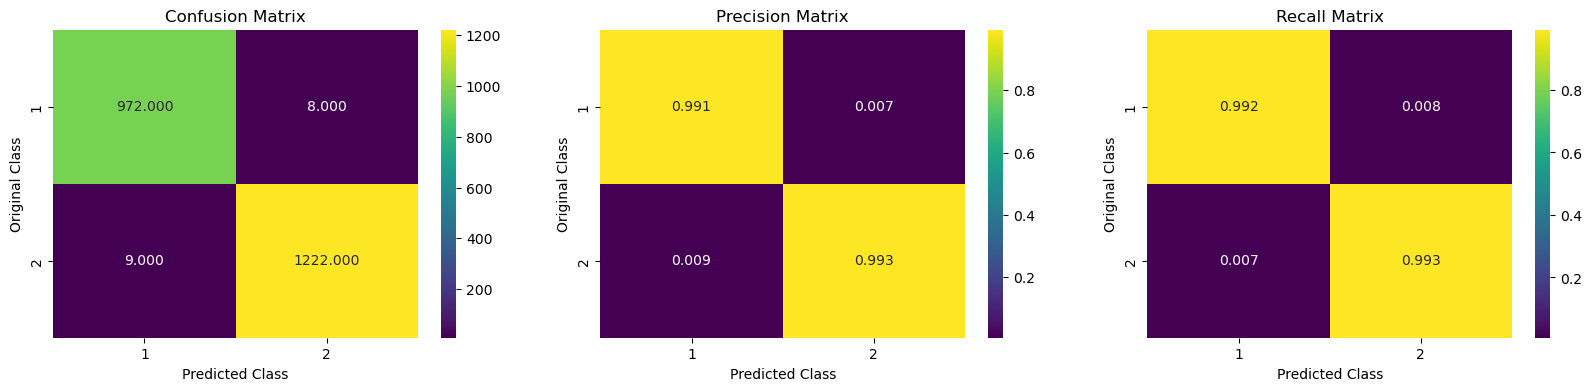

In [38]:
plot_confusion_matrix(y_test, y_pred)

### Cross Validation Score

In [31]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_clf,X_reduced, y, cv=5)

print(f"Cross-validated scores: {scores}")
print(f"Mean cross-validated score: {scores.mean()}")

Cross-validated scores: [0.98190864 0.97919493 0.97964722 0.960199   0.94843962]
Mean cross-validated score: 0.9698778833107191


### Visualizing the train, test set accuracy

In [32]:
from sklearn.metrics import accuracy_score
# Lists to store number of trees and training accuracy
n_estimators = []
train_accuracies = []

# Manually grow the forest and track accuracy after adding more trees
for n_trees in range(1, grid_search.best_params_['n_estimators']):  # 1 to n trees
    best_clf.n_estimators = n_trees  # Increase the number of trees
    best_clf.fit(X_train, y_train)   # Fit the model with the updated number of trees
    
    # Predict on the training set and calculate accuracy
    y_pred_train = best_clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    
    # Store the number of trees and accuracy
    n_estimators.append(n_trees)
    train_accuracies.append(train_accuracy)

In [33]:
from sklearn.metrics import accuracy_score
# Lists to store number of trees and test accuracy
n_estimators = []
test_accuracies = []

# Manually grow the forest and track accuracy after adding more trees
for n_trees in range(1, grid_search.best_params_['n_estimators']):  # 1 to n trees
    best_clf.n_estimators = n_trees  # Increase the number of trees
    best_clf.fit(X_test, y_test)   # Fit the model with the updated number of trees
    
    # Predict on the training set and calculate accuracy
    y_pred_test = best_clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    # Store the number of trees and accuracy
    n_estimators.append(n_trees)
    test_accuracies.append(test_accuracy)

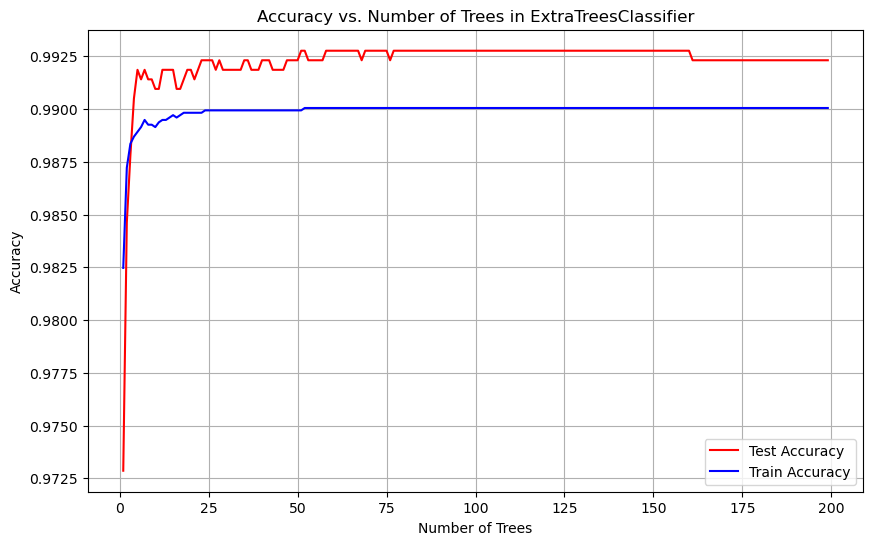

In [34]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, test_accuracies, label='Test Accuracy', color='red')
plt.plot(n_estimators, train_accuracies, label='Train Accuracy', color='blue')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Trees in ExtraTreesClassifier')
plt.legend()
plt.grid(True)
plt.show()

## Performance

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

# Step 1: Make predictions on the test set
y_pred = best_clf.predict(X_test)

# Step 2: Calculate performance metrics

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred)

# Recall (Sensitivity)
recall = recall_score(y_test, y_pred)

# F1-Score
f1 = f1_score(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Print all the metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC-AUC Score: {roc_auc:.2f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Step 3: Detailed classification report (precision, recall, f1-score, and support for each class)
print(classification_report(y_test, y_pred))

Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1-Score: 0.99
ROC-AUC Score: 0.99
Confusion Matrix:
 [[ 972    8]
 [   9 1222]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1231

    accuracy                           0.99      2211
   macro avg       0.99      0.99      0.99      2211
weighted avg       0.99      0.99      0.99      2211

